# Jupyter Notebook: Klassifikation mit einem Multi Layer Perceptron in PyTorch

In diesem Notebook werden wir ein **Multi Layer Perceptron (MLP)** mit **PyTorch** erstellen, um eine Klassifikationsaufgabe auf tabellarischen Daten durchzuführen. Wir verwenden den **Adult Income Dataset**, der demografische Informationen enthält und die Aufgabe stellt, vorherzusagen, ob eine Person ein Einkommen über oder unter 50.000 USD hat. Dies ist eine binäre Klassifikationsaufgabe.

Das Notebook ist in folgende Abschnitte unterteilt:
1. **Datenvorbereitung**: Laden, Bereinigen und Vorbereiten des Datensatzes.
2. **Erstellen von PyTorch Datasets und Dataloaders**: Umwandeln der Daten in ein für PyTorch geeignetes Format.
3. **Definition des MLP-Modells**: Erstellen eines einfachen MLP mit einer versteckten Schicht.
4. **Training des Modells**: Verwenden des Adam-Optimizers und der Cross-Entropy-Loss-Funktion.
5. **Evaluation des Modells**: Berechnen von Metriken wie Accuracy, Precision, Recall und F1-Score sowie Visualisierung der Confusion Matrix.

Jeder Abschnitt enthält Erklärungen und Code, um den Studierenden ein tiefes Verständnis der Konzepte zu vermitteln.

## 1. Datenvorbereitung

Zuerst müssen wir den Datensatz laden und vorbereiten. Der **Adult Income Dataset** enthält sowohl numerische als auch kategorische Merkmale, die wir verarbeiten müssen.

### 1.1 Datensatz laden

Der Datensatz kann von [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/adult) heruntergeladen werden. Für dieses Beispiel laden wir ihn direkt aus dem Internet.

In [3]:
import pandas as pd

# URL des Datensatzes
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Spaltennamen
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

# Daten laden
data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)

# Erste Zeilen anzeigen
print(data.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

### 1.2 Daten bereinigen

Wir entfernen Zeilen mit fehlenden Werten und kodieren kategorische Variablen in numerische Werte.

In [4]:
# Fehlende Werte entfernen
data = data.dropna()

# Kategorische Variablen in numerische umwandeln
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "income"]
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Zielvariable (income) extrahieren
X = data.drop("income", axis=1)
y = data["income"]

### 1.3 Daten in Trainings-, Validierungs- und Testsets aufteilen

Wir teilen den Datensatz in 70% Training, 15% Validierung und 15% Test.

In [5]:
from sklearn.model_selection import train_test_split

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Aufteilung des Trainingsdatensatzes in Trainings- und Validierungsdaten
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)  # 0.1765 * 85% ≈ 15%

### 1.4 Daten skalieren

Da neuronale Netze empfindlich auf die Skalierung der Eingabedaten reagieren, standardisieren wir die numerischen Merkmale.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 2. Erstellen von PyTorch Datasets und Dataloaders

PyTorch arbeitet mit **Datasets** und **Dataloaders**, um Daten effizient zu laden und zu verarbeiten.

### 2.1 Benutzerdefiniertes Dataset erstellen

Wir erstellen ein benutzerdefiniertes Dataset, das die Daten in Tensoren umwandelt.

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class AdultDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)  # Annahme: y ist ein pandas Series

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Datasets erstellen
train_dataset = AdultDataset(X_train, y_train)
val_dataset = AdultDataset(X_val, y_val)
test_dataset = AdultDataset(X_test, y_test)

### 2.2 Dataloaders erstellen

Dataloaders ermöglichen das Laden der Daten in Batches und das Mischen der Daten.

In [61]:
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataloaders mit pin_memory=True, wenn CUDA verfügbar ist
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=device != "cpu")
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=device != "cpu")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=device != "cpu")

## 3. Definition des MLP-Modells

Ein **Multi Layer Perceptron (MLP)** besteht aus einer Eingabeschicht, einer oder mehreren versteckten Schichten und einer Ausgabeschicht. Für dieses Beispiel verwenden wir ein einfaches MLP mit einer versteckten Schicht.

### 3.1 Modellarchitektur

- **Eingabeschicht**: Die Anzahl der Neuronen entspricht der Anzahl der Merkmale (Features) im Datensatz.
- **Versteckte Schicht**: Wir wählen 64 Neuronen mit ReLU-Aktivierungsfunktion.
- **Ausgabeschicht**: 2 Neuronen (für die binäre Klassifikation) mit Softmax-Aktivierungsfunktion.

In [57]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Parameter
input_size = X_train.shape[1]  # Anzahl der Features
hidden_size = 128
num_classes = 2  # Binäre Klassifikation

# Modell instanziieren
model = MLP(input_size, hidden_size, num_classes)

model = model.to(device)

## 4. Training des Modells

Wir trainieren das Modell mit dem **Adam-Optimizer** und der **Cross-Entropy-Loss-Funktion**, die für Klassifikationsaufgaben geeignet ist.

### 4.1 Funktion zum Plotten der Verluste

Wir definieren eine Funktion, die die Trainings- und Validierungsverluste über die Epochen hinweg speichert und einen Plot erstellt.

In [20]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, num_epochs):
    """
    Plottet die Trainings- und Validierungsverluste über die Epochen.

    Args:
        train_losses (list): Liste der durchschnittlichen Trainingsverluste pro Epoche
        val_losses (list): Liste der durchschnittlichen Validierungsverluste pro Epoche
        num_epochs (int): Anzahl der Epochen
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Trainings- und Validierungsverluste über Epochen')
    plt.legend()
    plt.grid(True)
    plt.show()

### 4.2 Trainingsschleife

Wir trainieren das Modell für eine bestimmte Anzahl von Epochen und überwachen die Leistung auf dem Validierungsdatensatz.

/Users/nils/projects/fom/repos/exercise-fom-ai-bi/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/22, Train Loss: 0.3524, Val Loss: 0.3309
Epoch 2/22, Train Loss: 0.3321, Val Loss: 0.3237
Epoch 3/22, Train Loss: 0.3280, Val Loss: 0.3220
Epoch 4/22, Train Loss: 0.3265, Val Loss: 0.3210
Epoch 5/22, Train Loss: 0.3249, Val Loss: 0.3152
Epoch 6/22, Train Loss: 0.3244, Val Loss: 0.3211
Epoch 7/22, Train Loss: 0.3217, Val Loss: 0.3196
Epoch 8/22, Train Loss: 0.3209, Val Loss: 0.3176
Epoch 9/22, Train Loss: 0.3191, Val Loss: 0.3179
Epoch 10/22, Train Loss: 0.3156, Val Loss: 0.3138
Epoch 11/22, Train Loss: 0.3162, Val Loss: 0.3219
Epoch 12/22, Train Loss: 0.3151, Val Loss: 0.3147
Epoch 13/22, Train Loss: 0.3138, Val Loss: 0.3123
Epoch 14/22, Train Loss: 0.3127, Val Loss: 0.3197
Epoch 15/22, Train Loss: 0.3159, Val Loss: 0.3175
Epoch 16/22, Train Loss: 0.3117, Val Loss: 0.3132
Epoch 17/22, Train Loss: 0.3118, Val Loss: 0.3193
Epoch 18/22, Train Loss: 0.3104, Val Loss: 0.3170
Epoch 19/22, Train Loss: 0.3095, Val Loss: 0.3184
Epoch 20/22, Train Loss: 0.3112, Val Loss: 0.3169
Epoch 21/

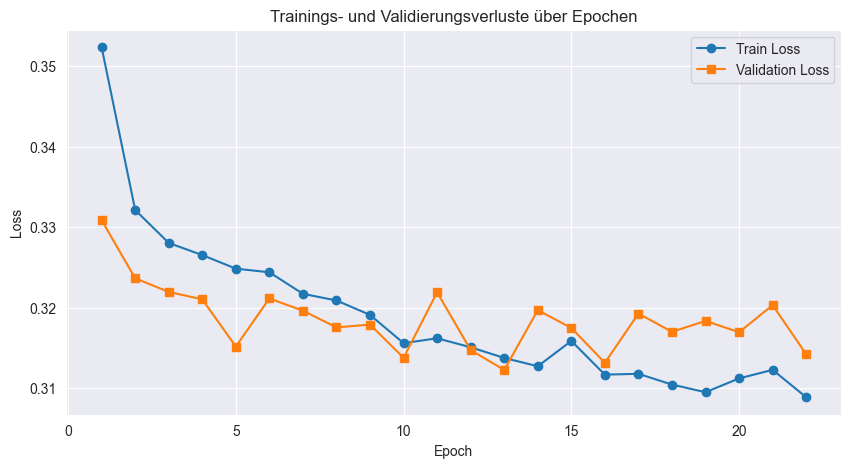

In [58]:
import torch.optim as optim

# Loss-Funktion und Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.007)

# Trainingsparameter
num_epochs = 22
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Daten auf das Gerät verschieben
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward Pass und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Durchschnittlichen Trainingsverlust speichern
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validierung
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Durchschnittlichen Validierungsverlust speichern
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Verluste plotten
plot_losses(train_losses, val_losses, num_epochs)

## 5. Evaluation des Modells

Nach dem Training evaluieren wir das Modell auf dem Testdatensatz mit gängigen Metriken wie **Accuracy**, **Precision**, **Recall** und **F1-Score**. Zusätzlich visualisieren wir die **Confusion Matrix**.

### 5.1 Metriken berechnen

Wir verwenden die Funktionen von `sklearn` zur Berechnung der Metriken.

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Modell auf Testdatensatz evaluieren
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metriken berechnen
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8571
Precision: 0.7781
Recall: 0.5865
F1-Score: 0.6689


/Users/nils/projects/fom/repos/exercise-fom-ai-bi/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


### 5.2 Confusion Matrix visualisieren

Die Confusion Matrix hilft uns, die Vorhersagen des Modells besser zu verstehen.

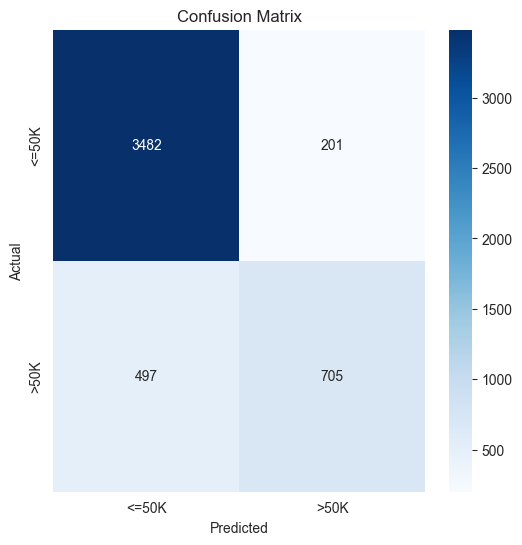

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix berechnen
cm = confusion_matrix(all_labels, all_preds)

# Plotten
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Zusammenfassung

In diesem Notebook haben wir ein Multi Layer Perceptron (MLP) mit PyTorch erstellt, um eine binäre Klassifikationsaufgabe auf dem Adult Income Dataset durchzuführen. Wir haben den Datensatz vorbereitet, PyTorch Datasets und Dataloaders erstellt, das MLP-Modell definiert und trainiert, und schließlich das Modell mit gängigen Metriken evaluiert. Die Confusion Matrix bietet eine visuelle Darstellung der Modellleistung.

Dieses Beispiel zeigt, wie Deep Learning auch auf tabellarischen Daten angewendet werden kann und dient als Einführung in die Verwendung von PyTorch für solche Aufgaben.

---

**Hinweis**: Stellen Sie sicher, dass alle erforderlichen Bibliotheken installiert sind, indem Sie `pip install pandas torch scikit-learn seaborn matplotlib` ausführen.